# Worksheet 17

Name: Hao Qi, Hui Zheng  
UID: U96305250, U80896784

### Topics

- Recommender Systems

### Recommender Systems

In the class example of recommending movies to users, we used the movie rating as a measure of similarity between users and movies. Thus, the predicted rating for a user is a proxy for how highly a movie should be recommended. The higher the predicted rating for a user, the higher a recommendation it would be. 

a) Consider a streaming platform that only has "like" or "dislike" (no 1-5 rating). Describe how you would build a recommender system in this case.

Build a recommender system using item-based collaborative filtering with the Jaccard similarity metric, given its simplicity and direct applicability to binary data (like or dislike): 

* Collect user interactions with items (here movies) in a binary form 
* Create the User-Item Matrix
    * Rows represent users
    * Columns represent items
    * Cells contain binary values: 1 if the user liked the item, 0 if the user disliked it
* Calculate the Jaccard similarity
* Generate recommendations
    * For each user:
        * Identify items they have not rated
        * Calculate a predicted score for each unrated item by aggregating the similarities of rated items weighted by the user's ratings
        * Sort these items by their predicted scores in descending order and generate the top K recommendations


b) Describe 3 challenges of building a recommender system. 

- **Sparse Data**: Sparse data complicates recommendations because there are often more items than ratings.  
- **Scalability and Performance**: As the number of users and items increases, the computational demands to generate recommendations escalate, requiring efficient algorithms to maintain performance.  
- **Cold Start Problem**: Recommender systems struggle with new users or items that lack historical data, requiring reliance on metadata or demographic information to make initial recommendations.  

c) Why is SVD not an option for collaborative filtering?

Traditional SVD is not directly applicable to collaborative filtering primarily due to the sparse nature of user-item interaction matrices, where most entries are missing. This means SVD, which requires a fully populated matrix, cannot be used without modifications. Additionally, traditional SVD struggles with scalability and lacks flexibility in integrating additional user or item metadata. Consequently, adaptations such as FunkSVD or SVD++ have been explicitly developed to handle missing values and incorporate additional contextual information. 

d) Use the code below to train a recommender system on a dataset of Amazon movies. 

In [70]:
# Note: requires py3.10
import findspark
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, confusion_matrix

from pyspark.sql import SparkSession
from pyspark import SparkConf, SparkContext
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator

findspark.init()
conf = SparkConf()
conf.set("spark.executor.memory", "28g")
conf.set("spark.driver.memory", "28g")
conf.set("spark.driver.cores", "8")
sc = SparkContext.getOrCreate(conf)
spark = SparkSession.builder.getOrCreate()

init_df = pd.read_csv("./train.csv").dropna()
init_df['UserId_fact'] = init_df['UserId'].astype('category').cat.codes
init_df['ProductId_fact'] = init_df['ProductId'].astype('category').cat.codes

# Split dataset into training and testing sets
X_train_processed, X_test_processed, Y_train, Y_test = train_test_split(
        init_df.drop(['Score'], axis=1),
        init_df['Score'],
        test_size=1/4.0,
        random_state=0)

X_train_processed['Score'] = Y_train
df = spark.createDataFrame(X_train_processed[['UserId_fact', 'ProductId_fact', 'Score']])

In [65]:
als = ALS(
        userCol="UserId_fact",
        itemCol="ProductId_fact",
        ratingCol="Score",
        coldStartStrategy="drop",       # nan
        nonnegative=True
)
param_grid = ParamGridBuilder().addGrid(
        als.rank, [10, 50, 100]).addGrid(
        als.regParam, [0.01, 0.1, 0.2]).addGrid(
        als.maxIter, [5, 10, 20]).build()
evaluator = RegressionEvaluator(
        metricName="rmse",
        labelCol="Score", 
        predictionCol="prediction")
cv = CrossValidator(estimator=als, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=3, parallelism=6)

cv_fit = cv.fit(df)
rec_sys = cv_fit.bestModel

In [71]:
rec_sys = als.fit(df)

In [18]:
# rec_sys.save('rec_sys.obj') 

In [72]:
rec = rec_sys.transform(spark.createDataFrame(X_test_processed[['UserId_fact', 'ProductId_fact']])).toPandas()

# find cold start problem here
rec

,UserId_fact,ProductId_fact,prediction
0,1138,3918,3.023197
1,1118,3179,0.724142
2,6915,4190,2.890679
3,6169,1460,1.859119
4,5830,4186,1.299382
...,...,...,...
206,7447,6247,1.687569
207,7629,18,1.225082
208,4279,4106,0.277838
209,3756,6634,0.401776


Kaggle RMSE =  1.6664933243190625


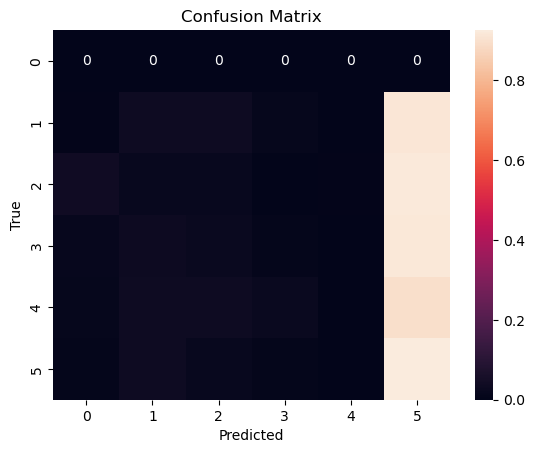

In [73]:
import random

substitute = Y_train.value_counts().head(1).index.tolist()

def fill_with_random(item):
    if pd.isna(item):
        return random.choice(substitute)
    else:
        return item

X_test_processed = X_test_processed.merge(rec, on=['UserId_fact', 'ProductId_fact'], how='left')
# X_test_processed['Score'] = X_test_processed['prediction'].fillna(X_test_processed['prediction'].mean()).round().astype(int)
X_test_processed['Score'] = X_test_processed['prediction'].apply(fill_with_random).round().astype(int)

print("Kaggle RMSE = ", mean_squared_error(X_test_processed['Score'], Y_test, squared=False))

cm = confusion_matrix(Y_test, X_test_processed['Score'], normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()